This is a pretty generic walkthrough of ViT on some toy datasets, hopefully demonstrating how we can set this up en-masse for a variety of experiments. 

# Vision Transformer

## Import Libraries

In [42]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

#from vit_pytorch.efficient import ViT


In [2]:
print(f"Torch: {torch.__version__}")

Torch: 1.8.1+cu102


In [3]:
# Training settings
batch_size = 64
epochs = 25
lr = 3e-5
gamma = 0.7
seed = 42

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [5]:
device = 'cuda'

## Load Data

In [7]:
#TODO: Other data, transforms, etc. 


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                     #  transforms.Grayscale(num_output_channels=1),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                    #   transforms.Grayscale(num_output_channels=1),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

## Random Plots

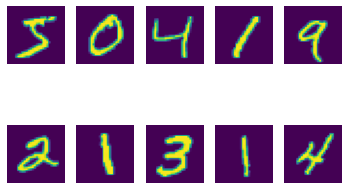

In [10]:

# show some images
#plt.figure(figsize=(4, 1.5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    #plt.imshow(image.squeeze().numpy(),cmap='gray')
    plt.imshow(image.numpy().transpose(1,2,0))
    plt.axis('off');

## Split

In [11]:
train_loader.dataset.__len__()

60000

In [12]:
print(f"Train Data: {train_loader.dataset.__len__()}")
print(f"Test Data: {test_loader.dataset.__len__()}")


Train Data: 60000
Test Data: 10000


### Visual Transformer

In [17]:
import sys
sys.path.append('../vit_pytorch/')
sys.path.append('..')

In [18]:

from vit import ViT

In [19]:
from recorder import Recorder # import the Recorder and instantiate
rec = Recorder()

In [22]:
model = ViT(
    dim=128,
    image_size=32,
    patch_size=4,
    num_classes=10,
  #  transformer=efficient_transformer,
    channels=1,
    depth = 3, heads=5, mlp_dim=32
).to(device)

In [23]:
model

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
    (1): Linear(in_features=16, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (to_qkv): Linear(in_features=128, out_features=960, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=320, out_features=128, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=128, out_features=32, bias=True)
              (1): GELU()
              (2): Dropout(p=0.0, inplace=False)
           

### Training

In [173]:
#TODO: another experiment? 
from madgrad import MADGRAD

In [24]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
# TODO: weight decay
optimizer = optim.Adam(model.parameters(), lr=lr)
#optimizer = MADGRAD(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [25]:


for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in test_loader: # interchangable with val for this toy experiment
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += 1000*acc / test_loader.dataset.__len__() #I had to add 1000 here and it worked for whatever reason. 
            epoch_val_loss += 1000*val_loss / test_loader.dataset.__len__()

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 1 - loss : 1.0062 - acc: 0.6858 - val_loss : 0.3738 - val_acc: 0.9004



  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.3082 - acc: 0.9154 - val_loss : 0.2476 - val_acc: 0.9328



  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.2200 - acc: 0.9382 - val_loss : 0.1972 - val_acc: 0.9445



  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.1747 - acc: 0.9506 - val_loss : 0.1646 - val_acc: 0.9524



  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.1467 - acc: 0.9577 - val_loss : 0.1487 - val_acc: 0.9568



  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.1289 - acc: 0.9631 - val_loss : 0.1329 - val_acc: 0.9593



  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.1144 - acc: 0.9665 - val_loss : 0.1223 - val_acc: 0.9621



  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.1032 - acc: 0.9697 - val_loss : 0.1140 - val_acc: 0.9656



  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.0938 - acc: 0.9722 - val_loss : 0.1120 - val_acc: 0.9652



  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.0859 - acc: 0.9746 - val_loss : 0.1128 - val_acc: 0.9642



  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.0806 - acc: 0.9757 - val_loss : 0.1034 - val_acc: 0.9670



  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.0742 - acc: 0.9780 - val_loss : 0.0958 - val_acc: 0.9697



  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.0700 - acc: 0.9792 - val_loss : 0.0915 - val_acc: 0.9715



  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.0649 - acc: 0.9806 - val_loss : 0.0895 - val_acc: 0.9721



  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.0602 - acc: 0.9818 - val_loss : 0.0872 - val_acc: 0.9730



  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.0564 - acc: 0.9831 - val_loss : 0.0853 - val_acc: 0.9740



  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.0526 - acc: 0.9844 - val_loss : 0.0799 - val_acc: 0.9750



  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.0497 - acc: 0.9849 - val_loss : 0.0928 - val_acc: 0.9702



  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.0460 - acc: 0.9864 - val_loss : 0.0859 - val_acc: 0.9733



  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.0429 - acc: 0.9876 - val_loss : 0.0790 - val_acc: 0.9757



  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 21 - loss : 0.0411 - acc: 0.9878 - val_loss : 0.0773 - val_acc: 0.9762



  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 22 - loss : 0.0380 - acc: 0.9889 - val_loss : 0.0773 - val_acc: 0.9750



  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 23 - loss : 0.0356 - acc: 0.9895 - val_loss : 0.0757 - val_acc: 0.9757



  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 24 - loss : 0.0330 - acc: 0.9899 - val_loss : 0.0778 - val_acc: 0.9764



  0%|          | 0/938 [00:00<?, ?it/s]

Epoch : 25 - loss : 0.0313 - acc: 0.9908 - val_loss : 0.0808 - val_acc: 0.9764



In [26]:
preds = model(data, rec = rec) # pass in the recorder


In [29]:
j = 4
attn_mat = rec.attn[j].cpu()
im = data[j].cpu().numpy().transpose(1,2,0)
attn_mat = torch.mean(attn_mat, dim=1) # average across heads 
# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(attn_mat.size(1))
aug_att_mat = attn_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)
# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    
# combines all the different layers which apply attention. 

# Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), (28,28))[..., np.newaxis]
result = (mask * im.astype("uint8"))

In [38]:
im.shape

(28, 28, 1)

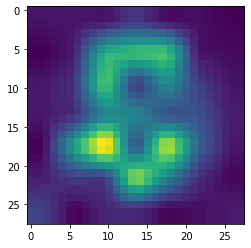

In [39]:
plt.imshow(mask)

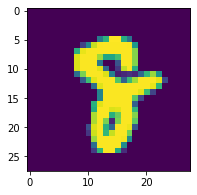

In [40]:
plt.figure(figsize=(3,3))
plt.imshow(im)

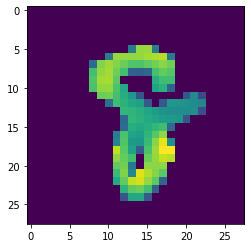

In [41]:
plt.imshow(result)

The attention is being paid to the entire image. Is this overfitting? 